In [8]:
from Minesweeper import *
from MS_GUI import *
from MS_AI import *
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

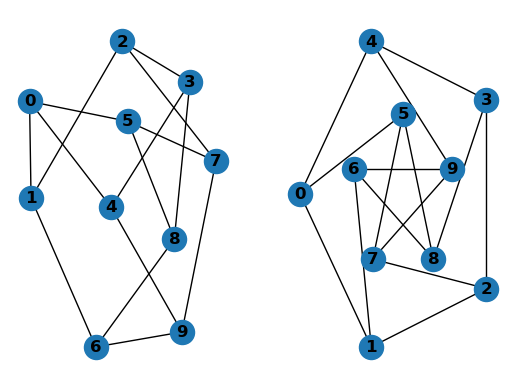

In [9]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

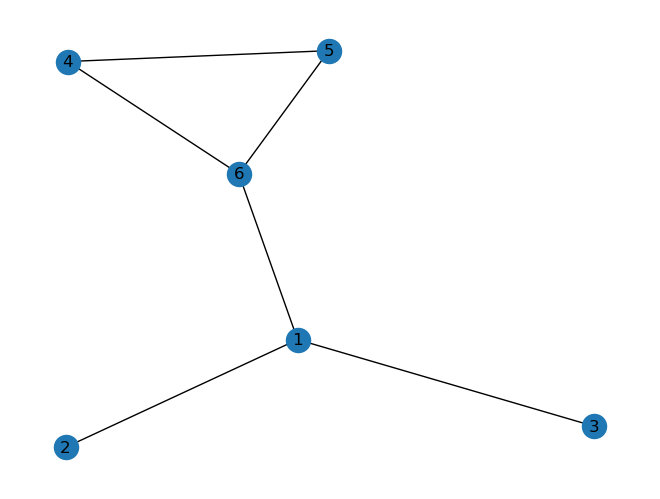

In [15]:
graph = nx.Graph()

graph.add_node(1, number=True)
graph.add_node(2, number=False)
graph.add_node(3, number=False)
graph.add_edge(1, 2, foo="bar")
graph.add_edge(1, 3, foo="boof")

graph.add_node(4, number=True)
graph.add_node(5, number=False)
graph.add_node(6, number=False)
graph.add_edge(4, 5, foo="foob")
graph.add_edge(4, 6, foo="rab")
graph.add_edge(6, 1)
graph.add_edge(5, 6)

nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph))